In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from superpoint.models.superpoint_pytorch import SuperPoint
from accelerated_features.modules.xfeat import XFeat

In [2]:
img_path = "aerial-image.jpeg"
img_path = "UFRGS-01-2017.png"
weights_path = "SuperPoint/weights/superpoint_v6_from_tf.pth"
img = Image.open(img_path).convert("L")
input = {"image": transforms.ToTensor()(img).unsqueeze(0)} # from (1, H, W) to (1, 1, H, W)

In [3]:
def generate_random_keypoints(image_shape, num_keypoints, device="cpu", dtype=torch.float32):
    """
    Gera keypoints aleatórios dentro dos limites de uma imagem.

    Args:
        image_shape: tuple (H, W) ou (B, C, H, W)
        num_keypoints: int, número de keypoints a gerar
        device: str, 'cpu' ou 'cuda'
        dtype: torch.dtype, tipo dos valores

    Returns:
        torch.Tensor (B, num_keypoints, 2): coordenadas (x, y)
    """
    # Extrai H e W mesmo que venha de shape de tensor 4D
    if len(image_shape) == 4:
        _, _, H, W = image_shape
        B = image_shape[0]
    elif len(image_shape) == 2:
        H, W = image_shape
        B = 1
    else:
        raise ValueError("image_shape deve ser (H, W) ou (B, C, H, W).")

    # Gera coordenadas uniformes dentro da imagem
    xs = torch.rand((B, num_keypoints, 1), device=device, dtype=dtype) * (W - 1)
    ys = torch.rand((B, num_keypoints, 1), device=device, dtype=dtype) * (H - 1)
    
    keypoints = torch.cat([xs, ys], dim=-1)
    return keypoints

In [4]:
#extractor = SuperPoint(
#        nms_radius= 4,
#        max_num_keypoints= 50000,
#        detection_threshold= 0.005,
#        remove_borders= 4,
#        descriptor_dim= 256,
#        channels= [64, 64, 128, 128, 256])

#weights = torch.load(weights_path, map_location="cuda")
#extractor.load_state_dict(weights)
#_ = extractor.eval()

#print(input["image"].shape)
#output = extractor(input)

#for key,values in output.items():
#    print(f"{key}: {values[0].shape}")

In [10]:
xfeat = XFeat()
particles_kpts = generate_random_keypoints((4800, 4800), num_keypoints=5000, device="cuda")
#particles_kpts = torch.tensor(
#    [[200,200], [500,500], [800,800], [1200,1200], [2000,2000]],
#    device="cuda", dtype=torch.float32
#).unsqueeze(0)
print(particles_kpts.shape)
print(input["image"].shape)
output = xfeat.computeAtKeypoints(input["image"], particles_kpts)#)top_k = 50000)
#output = xfeat.detectAndCompute(input["image"], top_k = 50000)

loading weights from: /home/navms-pdi2/Documentos/lucas-benedetti/01-feature-extraction/accelerated_features/modules/../weights/xfeat.pt
torch.Size([1, 5000, 2])
torch.Size([1, 1, 4800, 4800])


In [11]:
output

[{'keypoints': tensor([[1529.9802, 1943.2230],
          [3254.5332, 3794.9187],
          [4197.8159,  291.8242],
          ...,
          [3884.6497, 4368.5400],
          [4091.0535, 4506.7495],
          [2218.0073, 2244.8660]], device='cuda:0'),
  'descriptors': tensor([[ 0.1749,  0.0026, -0.0530,  ..., -0.0215,  0.0600, -0.0785],
          [ 0.2381,  0.0055,  0.1509,  ..., -0.0562, -0.0082, -0.1185],
          [ 0.1895,  0.0440,  0.0872,  ...,  0.0373,  0.0881,  0.2321],
          ...,
          [ 0.2040, -0.0093,  0.0807,  ..., -0.0813,  0.0141, -0.0469],
          [ 0.1944, -0.0376,  0.2486,  ..., -0.1579, -0.0105, -0.0084],
          [ 0.2792, -0.0671, -0.1393,  ..., -0.1552,  0.0242,  0.0103]],
         device='cuda:0', grad_fn=<SelectBackward0>)}]

In [12]:
for key,values in output[0].items():
    print(f"{key}: {values.shape}")

keypoints: torch.Size([5000, 2])
descriptors: torch.Size([5000, 64])


keypoints: torch.Size([5000, 2])
descriptors: torch.Size([5000, 64])


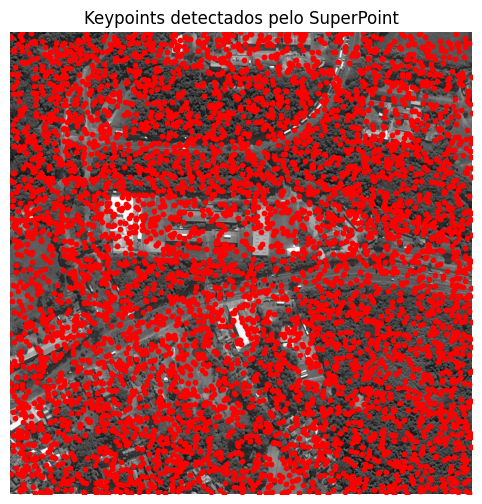

In [13]:
for key,values in output[0].items():
    print(f"{key}: {values.shape}")

keypoints = output[0].get("keypoints", None)

if keypoints is not None:
    keypoints = keypoints.detach().cpu().numpy()  # [N,2]
    plt.figure(figsize=(8,6))
    plt.imshow(img, cmap="gray")
    plt.scatter(keypoints[:,0], keypoints[:,1], c='r', s=10)  # x,y
    plt.title("Keypoints detectados pelo SuperPoint")
    plt.axis("off")
    plt.show()
else:
    print("A saída não contém 'keypoints'. Verifique as chaves disponíveis:", output.keys())